# Hierarchical Cross-Validation Evaluation

Contents
1.   [Libraries](#cell-1)
2.   [Auxiliary Functions](#cell-2)
3.   [Baseline CRPS Function](#cell-3)
4.   [Run Baselines](#cell-4)



<a name="cell-1"></a>
# 1. Libraries

In [2]:
%%capture
!pip install numba statsforecast datasetsforecast
!pip install git+https://github.com/Nixtla/neuralforecast.git
!pip install git+https://github.com/Nixtla/hierarchicalforecast.git
!git clone https://github.com/dluuo/HINT.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Nixtla/neuralforecast.git to /tmp/pip-req-build-6jrof9jq
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/neuralforecast.git /tmp/pip-req-build-6jrof9jq
  Resolved https://github.com/Nixtla/neuralforecast.git to commit ca216176eea7b91d696b300022599ce623a7ce9a
  Preparing metadata (setup.py) ... done
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Nixtla/hierarchicalforecast.git to /tmp/pip-req-build-aip7co0d
  Running command git clone --filter=blob:none --quiet https://github.com/Nixtla/hierarchicalforecast.git /tmp/pip-req-build-aip7co0d
  Resolved https://github.com/Nixtla/hierarchicalforecast.git to commit 3336197f44463c94a152cb180d2eec34f95c7b79
  

In [3]:
# %%capture
import numpy as np
import pandas as pd
import os
import re

from ray import tune

#import wrangled datasets
from HINT.src.data.data import HierarchicalDataset

# Base forecasts
from statsforecast.core import StatsForecast
from statsforecast.models import ETS, AutoARIMA, SeasonalNaive, Naive

# Reconciliation and evaluation
from hierarchicalforecast.core import HierarchicalReconciliation
from hierarchicalforecast.evaluation import HierarchicalEvaluation, scaled_crps
from hierarchicalforecast.methods import BottomUp, TopDown, MiddleOut, MinTrace, ERM
from hierarchicalforecast.utils import CodeTimer

from neuralforecast import NeuralForecast
from neuralforecast.models import NHITS
from neuralforecast.auto import AutoNHITS
from neuralforecast.losses.pytorch import PMM, GMM, DistributionLoss


import matplotlib.pyplot as plt

<a name="cell-2"></a>
# 2. Auxiliary Functions



In [4]:
def sort_df_hier(Y_df, S):
    Y_df.unique_id = Y_df.unique_id.astype('category')
    Y_df.unique_id = Y_df.unique_id.cat.set_categories(S.index)
    Y_df = Y_df.sort_values(by=['unique_id', 'ds'])

    return Y_df

In [5]:
def get_hierarchical_crps(data, Y, Y_hat, q_to_pred, model_name='current'):
    hier_idxs   = data['hier_idxs']
    crps_list = []
    for i, idxs in enumerate(hier_idxs):
        # Get the series specific to the hierarchical level
        y     = Y[idxs, :]
        y_hat = Y_hat[idxs, :, :]

        crps  = scaled_crps(y, y_hat, q_to_pred)
        crps_list.append(crps)

    return crps_list

<a name="cell-3"></a>
# 3. Baseline CRPS Function

In [6]:
def run_baselines(dataset, n_components, verbose=False):
    with CodeTimer('Read and Parse data   ', verbose):
        hdataset = HierarchicalDataset()
        data = hdataset.load_process_data(dataset=dataset)

        #import Y_df and remove future df NaNs
        Y_df = data['Y_df'][data['Y_df']['y'].notna()]
        Y_df['ds'] = pd.to_datetime(Y_df['ds'])  

        #import S, tags, properties
        S, tags = data['S_df'], data['tags']
        frequency, seasonality, horizon = data['freq'], data['seasonality'], data['horizon']

        # --Modeling parameters--
        season_length = seasonality
        horizon_len = horizon
        freq = frequency
        n_windows_cv = 1
        n_series = len(Y_df.unique_id.unique())
        num_components = n_components

        #create level and quantiles
        level = np.arange(2, 100, 2)
        qs = [[50-l/2, 50+l/2] for l in level] 
        quantiles = np.sort(np.concatenate(qs)/100)

    with CodeTimer('Fit/Predict Model	 ', verbose):

        dataset_to_model = {'Labour':NHITS(h=horizon, 
                                        input_size=3 * horizon,
                                        batch_size=64,
                                        futr_exog_list = [f'y_[lag{seasonality}]'],
                                        loss=GMM(n_components=num_components, level=list(level)),
                                        random_seed = 18,
                                        scaler_type='robust',
                                        learning_rate=0.001,
                                        max_epochs=250),
                            'Traffic':NHITS(h=horizon, 
                                        input_size=3 * horizon,
                                        batch_size=64,
                                        futr_exog_list = [f'y_[lag{seasonality}]'],
                                        loss=GMM(n_components=num_components, level=list(level)),
                                        random_seed = 18,
                                        scaler_type='robust',
                                        learning_rate=0.001,
                                        max_epochs=150),
                            'TourismLarge':NHITS(h=horizon, 
                                        input_size=3 * horizon,
                                        batch_size=64,
                                        futr_exog_list = [f'y_[lag{seasonality}]'],
                                        loss=GMM(n_components=num_components, level=list(level)),
                                        random_seed = 18,
                                        scaler_type='robust',
                                        learning_rate=0.001,
                                        max_epochs=100)}
        
        models = [dataset_to_model[dataset]]

        #fit and predict
        fcst = NeuralForecast(models=models, freq=frequency)

        # Obtain forecast predictions
        Y_hat_df = fcst.cross_validation(df=Y_df,
                                        n_windows=n_windows_cv)
        
        #sort raw predictions by uid to make sure they are hierarchically ordered
        Y_hat_df = sort_df_hier(Y_hat_df, S)

        # Group by cutoff date
        Y_hat_group_df = Y_hat_df.groupby(['cutoff'])

    with CodeTimer('Evaluate Models	   ', verbose):
        #turn Y_hat_df from grouped dataframe to normal dataframe and sort by cutoff/uid
        Y_hat_sort_df = Y_hat_group_df.apply(lambda x: x)
        Y_hat_sort_df = Y_hat_sort_df.sort_values(by=['cutoff','unique_id'])

        #extract just y predictions to get Y_test
        Y_test_df = Y_hat_sort_df['y']

        #drop all columns that aren't quantile predictions
        #keep only columns starting with NHITS-lo- or NHITS-hi-
        pattern = re.compile("^NHITS-(lo|hi)-")
        Y_hat_quantiles_df = Y_hat_sort_df.filter(regex=pattern)

        #convert dataframes to numpy and reshape
        Y_test_np = Y_test_df.values.reshape(n_windows_cv, n_series, horizon_len, 1)
        Y_hat_np = Y_hat_quantiles_df.values.reshape(n_windows_cv, n_series, horizon_len, -1)

        crps_list = [get_hierarchical_crps(data, 
                                            Y=Y_test_np[window,:,:,0], 
                                            Y_hat=Y_hat_np[window,:,:,:], 
                                            q_to_pred=quantiles) for window in range(n_windows_cv)]

        crps_list_np = np.array(crps_list)
        crps_avg_np = np.average(crps_list_np, axis=0)

        overall_crps = crps_avg_np[0]

        return overall_crps


<a name="cell-4"></a>
# 4. Run Baselines

In [7]:
%%capture
verbose = False

n_components_list = [1, 10, 25, 50, 100]
dataset_list = ['Labour', 'Traffic', 'TourismLarge']

ablation_dict = {}
ablation_dict['Components'] = n_components_list

for dataset in dataset_list: 
    ablation_dict[dataset] = []

for n_components in n_components_list:
    for dataset in dataset_list:
        overall_crps = run_baselines(dataset=dataset, n_components = n_components, verbose=verbose)
        ablation_dict[dataset].append(overall_crps)

ablation_df = pd.DataFrame(ablation_dict)
ablation_df

INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 18
INFO:lightning_fabric.utilities.seed:Global seed set to 

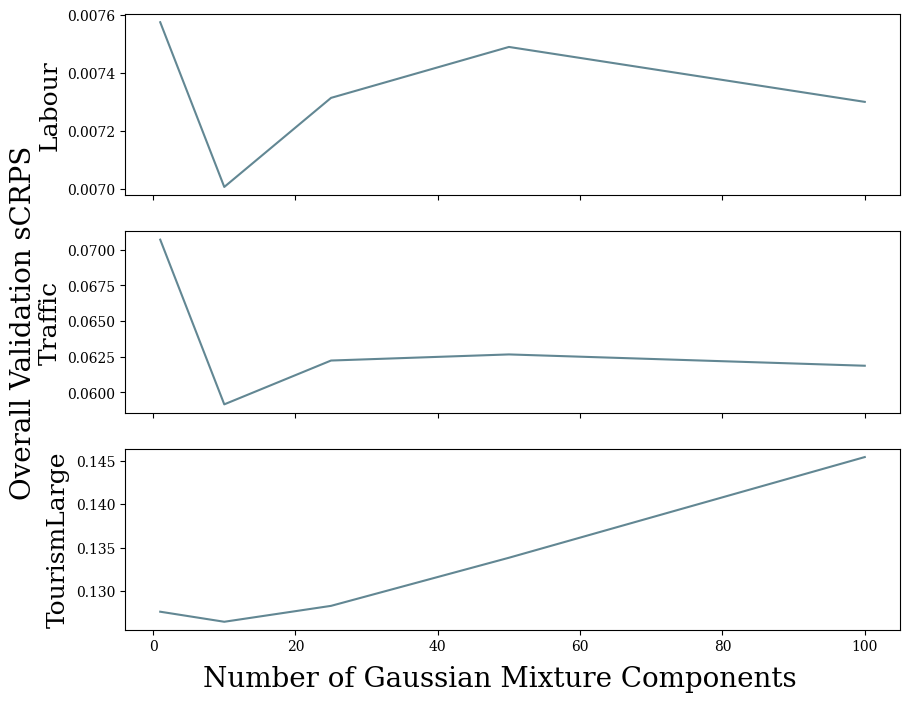

In [9]:
fig, axs = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(10, 8))

axs[0].plot(ablation_df['Components'].values, ablation_df['Labour'].values,
          color='#628793')
axs[0].set_ylabel('Labour', fontsize=18)

axs[1].plot(ablation_df['Components'].values, ablation_df['Traffic'].values,
          color='#628793')
axs[1].set_ylabel('Traffic', fontsize=18)

axs[2].plot(ablation_df['Components'].values, ablation_df['TourismLarge'].values,
          color='#628793')
axs[2].set_ylabel('TourismLarge', fontsize=18)

fig.text(0.5, 0.04, 'Number of Gaussian Mixture Components', ha='center', fontsize=20)
fig.text(0.01, 0.5, 'Overall Validation sCRPS ', va='center', rotation='vertical', fontsize=20)

plt.savefig("CRPSvsComponentsStudy.pdf", format="pdf", bbox_inches="tight")
plt.show()
plt.close()